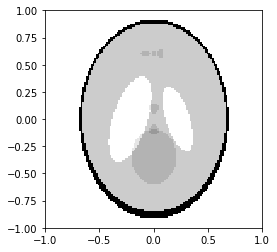

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tomograph

# show plot first run
%matplotlib inline 
# test autocompletion with tab or tab+shift
%config IPCompleter.greedy=True 

def show_phantom(size):
    """
    Hilfsfunktion um sich das Originalbild anzuschauen.
    """
    Im = tomograph.phantom(size)
    plt.imshow(Im, cmap='gist_yarg', extent=[-1.0, 1.0, -1.0, 1.0], interpolation='nearest')
    plt.show()


show_phantom(128)

GRID:  32
GRID:  64


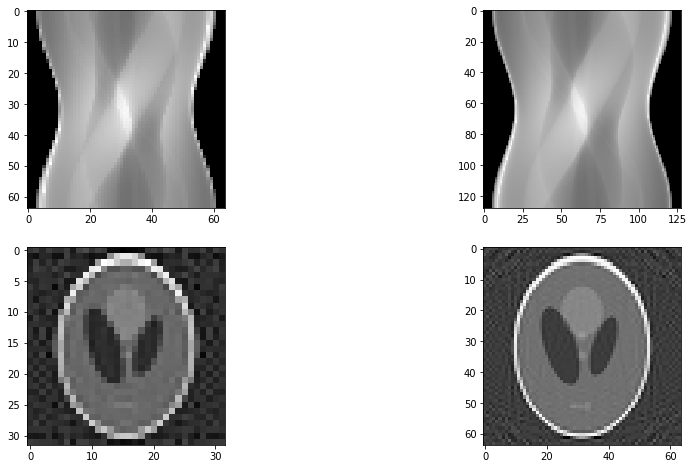

In [46]:
def create_sinogram(nAngles, nSamples, angle_range=(0, np.pi)):
    """
    Funktion soll Sinogram erzeugen

    :param angle_range: Winkel über die die Strahlen laufen in rad. default=(0-180 Grad)
    :param nAngles: Anzahl der Winkelschritte innerhalb der angle_range (Anzahl der Strahlenfronten)
    :param nSamples: Anzahl der Strahlen pro Winkel (Anzahl der Strahlen pro Strahlenfront)

    :return: Tuple sinogram matrix, Strahlstartpunkte, Strahlrichtungen
    """

    # Anlegen von leeren Matrizen für Strahlstart und -richtung
    # rp - Strahlstartpunkte: pro Winkelschritt, Anzahl der Strahlen pro Winkel viele x-y-Positionen
    # rd - Strahlrichtungen: pro Winkelschritt ein x-y-Richtung
    #print(type(nSamples))
    #print(nSamples)
    rp = np.zeros((nAngles,nSamples,2))
    rd = np.zeros((nAngles,2))
    
    # Der mittlere Strahlenstartpunkt der Strahlenfront liegt auf dem Einheitskreis.
    # An jedem mittlere Strahlenstartpunkt der Strahenfront soll entlang der
    # Tangente nach links und rechts gegangen werden um die Strahlstartwerte
    # zu berechnen.
    phi = np.linspace(0,np.pi,nAngles)
    #print(phi)
    #l = 1
    
    # Tipp: Mittlere Strahlenstartpunkt in Polarkoordinatendarstellung
    # repräsentieren und dann in x/y Position umwandeln.
    midBeamCenter = np.zeros((nAngles,2))
    midBeamCenter[:,0] = np.cos(phi) # x center
    midBeamCenter[:,1] = np.sin(phi) # y center
    #print(rp)
    
    # Tipp: Richtungsvektor der Strahlenfront ergibt sich auch direkt aus dem
    # mittlere Strahlenstartpunkt rd[i] -> np.array([-x, -y])
    rd = -1*midBeamCenter
    #print(rd)
    
    # Tipp: Die Strahlstartpositionen der Strahlenfront ergeben sich über
    # rp[i, j] = np.array([x,y]) + s*np.array([-y,x])
    # wobei s Anzahl Strahlen viele Skalierungsfaktoren zwischen -1 und 1 mit
    # gleichmäßigen Abständen (np.linspace)
    #s = np.linspace(-0.9,0.9,nSamples)
    s = np.linspace(-1.0,1.0,nSamples)

    # Ein sinogramm ist ein Array mit abgeschwaechten Intensitaeten pro Winkel
    # und Strahl, d.h. die Matrix ist ([Anzahl Strahlen] x [Anzahl der Winkel]),
    # bzw. Anzahl der Strahlen pro Aufnahme und die Anzahl der Aufnahmen.
    # sinogram = np.zeros((nAngles, nSamples))
    sinogram = np.zeros((nAngles, nSamples))

    # for i in AnzahlWinkel:
    #   for j in AnzahlSamples:
    #       trace-Funktion aufrufen und sinogram-Matrix füllen
    #       sinogram[i,j] = ...
    
    for i in range(nAngles):
        center = midBeamCenter[i,:]
        for j in range(nSamples):
            rp[i,j] = center + s[j]*np.array([-center[1],center[0]])
            sinogram[i,j] = tomograph.trace(rp[i,j], rd[i,:])
    
    return sinogram, rp, rd


# ---------------------------------------------
# Main Programablauf:
# ---------------------------------------------
gridsizes = [32,64] #,32]#,64] #, 128]  # , 128, 256]
# plot mit unterfigures
fig, ax = plt.subplots(nrows=2, ncols=len(gridsizes), figsize=(15, 8))
# Für alle Gridsizes:
for i,ng in enumerate(gridsizes):
    print("GRID: ", ng)
    nGrid = ng
    # die Anzahl der Winkelstufen
    nSamples = 2*nGrid # wird benötigt, bei gleicher Anzahl wie Grid singuläre Matrix oder keine/fehlerhafte Lösung
    nAngles = 2*nGrid

    # Erstellen Sie das Sinogram mithilfe Ihrer zuvor geschriebenen Funktion.
    Matrix, rp ,rd = create_sinogram(nAngles, nSamples)
    # Plotten Sie das Sinogram mit Hilfe von Matplotlib. Nutzen Sie die 'gist_yarg' color map
    ax[0][i].imshow(Matrix, cmap="gist_yarg")
    
    # Die bekannten aufgenommenen Intensitaetswerte im Sinogram speichern wir als ein Vektor (siehe np.ravel)
    # in logarithmierter Form ab
    b = np.ravel(Matrix,order='C')
    b = np.log(b)
    #print(Matrix[0,0:5])
    #print(b[0:5])
    
    # Initialisieren Sie eine Matrix A in der gewünschten Größe.
    A = np.zeros((nAngles*nSamples , gridsizes[i]*gridsizes[i]))
    # Für jeden Winkel und jeden Strahl fügen wir jetzt eine Zeile in das Gleichungsystem ein.
    # Dafür müssen Sie über alle Winkel die Funktion grid_intersect (Rückgabe -> I, G, dt)
    # nutzen. I[k] beinhaltet den Index des Strahls, der mit der länge dt[k]
    # den Quadrant G[k] schneidet. Die errechneten Strahllängen pro Quadrant
    # (Pixel) sind dann die Einträge in die Matrix A. Gucken Sie notfalls nochmal
    # die Vorlesungsunterlagen an.
    
    for n in range(nAngles):
        # n angles 
        #print('rp:',rp[n])
        I,G,dt = tomograph.grid_intersect(gridsizes[i], rp[n,:], rd[n])
        #print('gridsize:',gridsizes[i])
        #print('rp:',rp[n])
        #print('rd:',rd[n])
        """
        Berechnet die Schnitte eines Rasters mit einer Menge vorgegebener
        paralleler Strahlen.

        Parameter:
        n  : Höhe bzw. Breite des für die Rekonstruktion verwendeten Rasters
        r  : Startpunkte der Strahlen; gespeichert als Zeilen einer Matrix (ndarray)
        d  : Richtungsvektor der Strahlen (array_like)

        Rückgabe:
        I  : Array mit Indizes der Strahlen (ndarray)
        G  : Array mit Indizes der geschnittenen Quadranten (ndarray)
        dt : Array mit Längen der im Quadranten verlaufenen Schnitte (ndarray)
        """

        # Achtung!: Die Strahlen indices I beziehen sich immer nur lokal auf die Strahlen,
        # die an grid_intersect übergeben wurden um den richtigen Index in der Matrix
        # zu finden muss (i*nSamples+I) berechnet werden, wobei i die Laufvariabel
        # über alle Winkel(nAngles) ist.
        # Hier kann etwas Indexmagic stattfinden: A[i*nSamples+I, G] = dt
        # Das ist das gleiche wie:
        # for k in range(len(I)):
        #   A[i*nSamples+I[k], G[k]] = dt[k]
        #if n == 3:
        #    print(I)
        #    print(G)
        #    print(dt)
          
        #print('samples:',n*nSamples+I)
        #print('G:',G)
        #print('dt:',dt)
        #print('I:',I)
        #print('G:',G)
        #print('dt:',dt)
        #print('samples:',n*nSamples+I)
        A[n*nSamples+I, G] = dt
        
        #if n==1:
        #    break
            
        #for r in range(A.shape[0]):
        #    for c in range(A.shape[1]):
        #        if A[r,c]>0:
        #            print('A r:',r, 'Ac:', c, 'A:',A[r,c])
        
        
            
        # print(sum(A[]))
          
    ##print('r:',r,':',A[0,:])
    #print(A.shape)
    #for r in range(A.shape[0]):
    #    #for c in range(A.shape[1]):
    #    print('r:',r,':',A[r,:])
    # --------------------------------------------------------------------------
    # Bis hier hin kommt ihr mit der ersten Vorlesung!
    # Wer neugierig ist, kann np.linalg.lstsq(A, b) benutzen.
    # Was dahinter steckt wird nächste Woche erklärt.
    # --------------------------------------------------------------------------

    # Lösen des Ausgleichsproblems mit Hilfe von np.linalg.solve
    #print(A.shape)
    #print(b.shape)
    #print(A.shape)
    Ata = np.matmul(A.T,A)
   # for r in range(Ata.shape[0]):
    #    #for c in range(A.shape[1]):
    #    print('r:',r,':',Ata[r,:])
    
    Atb = np.matmul(A.T,b)
    #print(Ata.shape)
    #print(Atb.shape)
    
    #for r in range(Ata.shape[0]):
        #for c in range(A.shape[1]):
    #    print('r:',r,':',A[r,:])
    
    x = np.linalg.solve(Ata,Atb)
    #x = np.linalg.solve(A,b)
    #x = np.linalg.lstsq(A, b)
    #print('shape:',len(x))
    # Lösungsvektor wieder auf die gewünschte Form bringen - reshape() und
    # wieder exponieren.
    XRay = np.reshape(x,(gridsizes[i],gridsizes[i]))
    XRay = np.exp(XRay)

    #print(XRay[0:5,0:5])
    #XRay = np.log(XRay)
    #XRay = np.exp(1/XRay)
    #XRay = np.power(10,1.0/XRay)
    #print(XRay[0:5,0:5])
        
    # Plotten Sie die Rekonstruktion mit Hilfe von Matplotlib. Nutzen Sie die 'gist_yarg' color map
    # ax[1][i].imshow(Matrix, cmap="gist_yarg")
    ax[1][i].imshow(XRay, cmap="gist_yarg")


# plt.savefig('tg_fig.png', bbox_inches='tight')
plt.show()
